In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

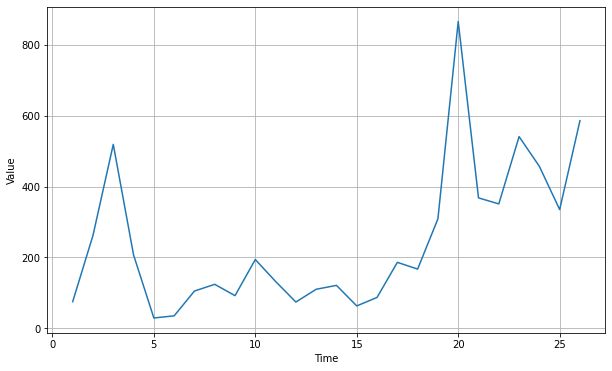

In [3]:
import csv
time_step = []
covid = []
step = 1

with open(r'../Dataset/2nd_Wave_dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        covid.append(float(row[1]))
        time_step.append(step)
        step += 1
        
series = np.array(covid)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
log_series = np.log(covid)

In [5]:
log_series

array([4.31748811, 5.5683445 , 6.25190388, 5.33271879, 3.36729583,
       3.55534806, 4.65396035, 4.82028157, 4.52178858, 5.26785816,
       4.88280192, 4.30406509, 4.70048037, 4.79579055, 4.14313473,
       4.46590812, 5.22574667, 5.11799381, 5.73334128, 6.76388491,
       5.90808294, 5.86078622, 6.29341928, 6.12468339, 5.81413053,
       6.37331979])

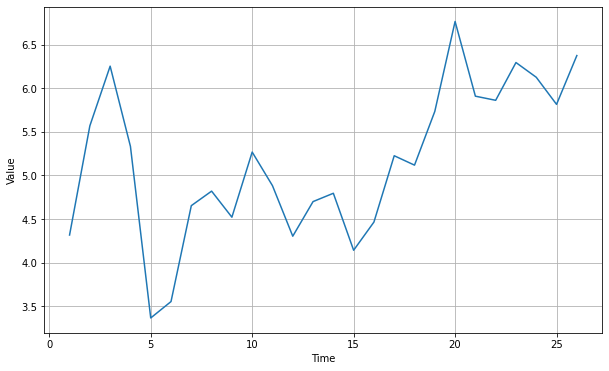

In [6]:
plt.figure(figsize = (10, 6))
plot_series(time, log_series)

In [7]:
split_time = 22
time_train = time[:split_time]
x_train = log_series[:split_time]
time_valid = time[split_time:]
x_valid = log_series[split_time:]

window_size = 20
batch_size = 3 ##changed from 22 to 3
shuffle_buffer_size = 20

In [8]:
def windowed_dataset(train_series, window_size, batch_size, shuffle_buffer):
    train_series = tf.expand_dims(train_series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(train_series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, train_series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(train_series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [87]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = window_size
batch_size = batch_size
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=10, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
  tf.keras.layers.Dense(20, activation="tanh"),
  #tf.keras.layers.Dropout(0),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=66, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(22,)
Epoch 1/66
1/1 [==============================] - 0s 6ms/step - loss: 303.7467 - mae: 304.2467
Epoch 2/66
1/1 [==============================] - 0s 965us/step - loss: 303.6895 - mae: 304.1895
Epoch 3/66
1/1 [==============================] - 0s 993us/step - loss: 303.5796 - mae: 304.0796
Epoch 4/66
1/1 [==============================] - 0s 2ms/step - loss: 303.4196 - mae: 303.9196
Epoch 5/66
1/1 [==============================] - 0s 1ms/step - loss: 303.2109 - mae: 303.7109
Epoch 6/66
1/1 [==============================] - 0s 2ms/step - loss: 302.9532 - mae: 303.4532
Epoch 7/66
1/1 [==============================] - 0s 893us/step - loss: 302.6452 - mae: 303.1452
Epoch 8/66
1/1 [==============================] - 0s 1ms/step - loss: 302.2846 - mae: 302.7846
Epoch 9/66
1/1 [==============================] - 0s 2ms/step - loss: 301.8678 - mae: 302.3678
Epoch 10/66
1/1 [======================

(1e-08, 0.0001, 0.0, 100.0)

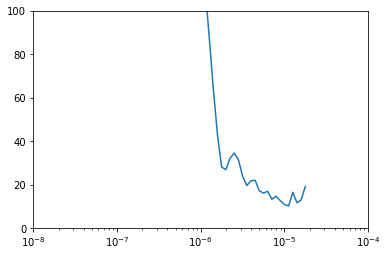

In [88]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 100])

In [89]:
rnn_forecast = model_forecast(model, log_series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

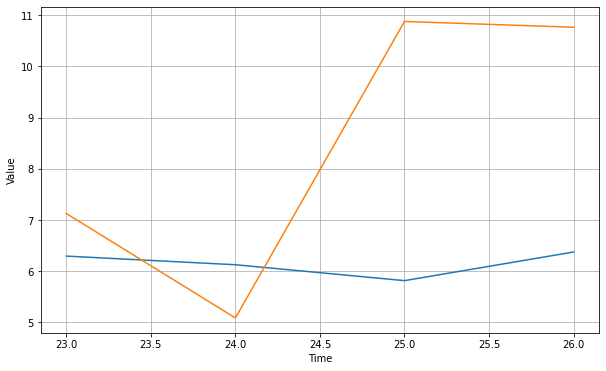

In [90]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [91]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.832046

In [92]:
print(rnn_forecast)

[ 7.1256967  5.0844936 10.878083  10.765084 ]
